In [1]:
from pymoo.optimize import minimize
from jobshop.params import job_params_from_json
from jobshop.heuristic.brkga import BRKGA, LSDecoder, JobShopProblem, DuplicatesEncoder
from jobshop.heuristic.brkga.termination import TargetTermination

Thesis with target values [link](https://repositorio.ufmg.br/bitstream/1843/33554/1/Tradu%C3%A7%C3%A3o%20Autom%C3%A1tica%20de%20Problemas%20de%20Escalonamento%20Job%20Shop%20Flex%C3%ADvel%20com%20Bloqueio%20para%20Aut%C3%B4matos%20Utilizando%20a%20Teoria%20de%20Controle%20Supervis%C3%B3rio%20-%20PDF_A.pdf)

In [2]:
params = job_params_from_json("./../instances/orlib/mt10.json")

In [9]:
brkga = BRKGA(
    pop_size=150,
    perc_elite=0.25,
    perc_mutants=0.1,
    bias=0.85,
    eliminate_duplicates=DuplicatesEncoder(1e-2),
)
problem = JobShopProblem(params, LSDecoder)

In [10]:
res = minimize(problem, brkga, termination=TargetTermination(3000, 933), verbose=True, seed=12)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      150 |  1.298713E+03 |  1.088000E+03
     2 |      263 |  1.266340E+03 |  1.086000E+03
     3 |      376 |  1.247533E+03 |  1.086000E+03
     4 |      489 |  1.237353E+03 |  1.084000E+03
     5 |      602 |  1.230207E+03 |  1.083000E+03
     6 |      715 |  1.226353E+03 |  1.042000E+03
     7 |      828 |  1.201087E+03 |  1.042000E+03
     8 |      941 |  1.208720E+03 |  1.042000E+03
     9 |     1054 |  1.203000E+03 |  1.042000E+03
    10 |     1167 |  1.205233E+03 |  1.042000E+03
    11 |     1280 |  1.197627E+03 |  1.042000E+03
    12 |     1393 |  1.184933E+03 |  1.036000E+03
    13 |     1506 |  1.188033E+03 |  1.036000E+03
    14 |     1619 |  1.197880E+03 |  1.036000E+03
    15 |     1732 |  1.189893E+03 |  1.030000E+03
    16 |     1845 |  1.190653E+03 |  1.030000E+03
    17 |     1958 |  1.173327E+03 |  1.001000E+03
    18 |     2071 |  1.177340E+03 |  1.001000E+03
    19 |     2184 |  1.169880E+03 |  1.001000E+03


In [11]:
graph = problem.decoder.build_graph_from_string(res.X)

In [35]:
graph.colors = graph.colors + (
    (0.6588235294117647, 0.3392156862745098, 0.6019607843137254),
    (0.5588235294117647, 0.6392156862745098, 0.2019607843137254),
)

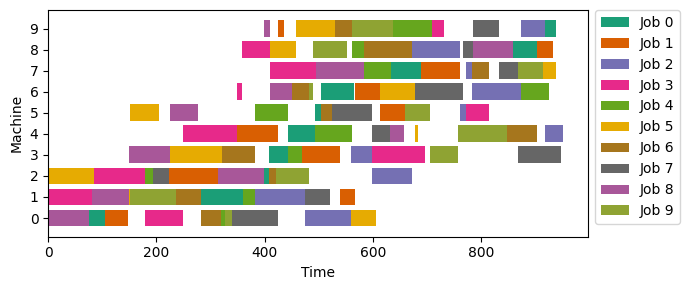

In [36]:
graph.plot()